# Imports

In [1]:
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F

from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
import matplotlib.pyplot as plt
import numpy as np
import cv2

import pandas as pd
import os

from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
import matplotlib.pyplot as plt

import albumentations as A
from PIL import Image

In [2]:
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [3]:
print(torch.__version__)
print(torchvision.__version__)

1.12.1+cu113
0.13.1+cu113


In [4]:
from pycocotools.coco import COCO

In [5]:
from albumentations.pytorch import ToTensorV2

# Check and set device

In [6]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla T4


# Transform function

In [7]:
mean = (0.2844, 0.3297, 0.5112)
std = (0.1717, 0.1611, 0.1796)

In [8]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            # A.Normalize(mean = mean, std = std),
            ToTensorV2()
            
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            # A.Normalize(mean = mean, std = std),
            ToTensorV2()            
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

# Dataset

In [9]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [13]:
# ! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download sharansmenon/aquarium-dataset
! unzip aquarium-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 84% 57.0M/68.0M [00:02<00:00, 28.6MB/s]
100% 68.0M/68.0M [00:02<00:00, 33.7MB/s]
Archive:  aquarium-dataset.zip
  inflating: Aquarium Combined/README.dataset.txt  
  inflating: Aquarium Combined/README.roboflow.txt  
  inflating: Aquarium Combined/test/IMG_2289_jpeg_jpg.rf.fe2a7a149e7b11f2313f5a7b30386e85.jpg  
  inflating: Aquarium Combined/test/IMG_2301_jpeg_jpg.rf.2c19ae5efbd1f8611b5578125f001695.jpg  
  inflating: Aquarium Combined/test/IMG_2319_jpeg_jpg.rf.6e20bf97d17b74a8948aa48776c40454.jpg  
  inflating: Aquarium Combined/test/IMG_2347_jpeg_jpg.rf.7c71ac4b9301eb358cd4a832844dedcb.jpg  
  inflating: Aquarium Combined/test/IMG_2354_jpeg_jpg.rf.396e872c7fb0a95e911806986995ee7a.jpg  
  inflating: Aquarium Combined/test/IMG_2371_jpeg_jpg.rf.54505f60b6706da151c164188c305849.jpg  
  inflating: Aquarium Combined/test/IMG_2379_jpeg_jpg.rf.7dc3160c937072d26d4624c6c48e904d.jpg  
  inflating: Aquarium Combined/test/IMG_2380_jpeg_

In [14]:
dataset_path = "Aquarium Combined/"

In [15]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [16]:
classes = [i[1]['name'] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [ ]:
dataset_path

In [17]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))
val_dataset = AquariumDetection(root=dataset_path, split = 'valid', transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


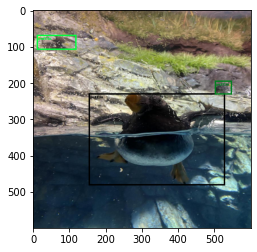

In [18]:
# Lets view a sample
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [19]:
len(train_dataset)

447

In [20]:
len(val_dataset)

127

# Model

Our model is FasterRCNN with a backbone of MobileNetV3-Large. We need to change the output layers because we have just 7 classes but this model was trained on 90 classes.

In [21]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

This is our collating function for the train dataloader, it allows us to create batches of data that can be easily pass into the model

In [22]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [23]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The following blocks ensures that the model can take in the data and that it will not crash during training

In [24]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error

In [68]:
output

{'loss_classifier': tensor(2.2124, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.6015, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.4763, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.1044, grad_fn=<DivBackward0>)}

In [37]:
targets[0]

{'boxes': tensor([[ 41.6667, 176.3672, 598.9583, 300.0000]]),
 'labels': tensor([5]),
 'image_id': tensor([442]),
 'area': tensor([68899.5312]),
 'iscrowd': tensor([0])}

In [26]:
model = model.to(device)

# Optimizer

In [27]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

# Training

In [28]:
import sys

## Train function for 1 epoch

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []
    
    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        print(loss_dict)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [ ]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

## Train function for n epochs

In [29]:
def show_plot(n_epochs, train_loss_values, val_loss_values):
  epochs = range(1,n_epochs+1)
  plt.plot(epochs, train_loss_values, 'r', label='Training loss')
  plt.plot(epochs, val_loss_values, 'y', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [30]:
def save_checkpoint(model, epoch, optimizer):
  state = {
      'model': model.state_dict(),
      'optimizer': optimizer.state_dict(),
  }
  torch.save(state, 'model_best_checkpoint.pth.tar')

In [31]:
def train_nn(model, optimizer, train_loader, val_loader, device, n_epochs):

  train_loss_values = []
  val_loss_values = []
  
  model.to(device)

  for epoch in range(n_epochs):
    model.train()

    all_losses = []
    all_losses_dict = []
    
    val_all_losses = []
    val_all_losses_dict = []

    for images, targets in tqdm(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)
        
        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    with torch.no_grad():
      for images, targets in tqdm(val_loader):
          images = list(image.to(device) for image in images)
          targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
          
          loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
          losses = sum(loss for loss in loss_dict.values())
          loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
          loss_value = losses.item()
          
          val_all_losses.append(loss_value)
          val_all_losses_dict.append(loss_dict_append)
          
          if not math.isfinite(loss_value):
              print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
              print(loss_dict)
              sys.exit(1)

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    val_all_losses_dict = pd.DataFrame(val_all_losses_dict) # for printing


    # print("Training | Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
    #     epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
    #     all_losses_dict['loss_classifier'].mean(),
    #     all_losses_dict['loss_box_reg'].mean(),
    #     all_losses_dict['loss_rpn_box_reg'].mean(),
    #     all_losses_dict['loss_objectness'].mean()
    # ))
    # print("Validation | Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
    #     epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
    #     val_all_losses_dict['loss_classifier'].mean(),
    #     val_all_losses_dict['loss_box_reg'].mean(),
    #     val_all_losses_dict['loss_rpn_box_reg'].mean(),
    #     val_all_losses_dict['loss_objectness'].mean()
    # ))

    train_loss_values.append(all_losses_dict['loss_classifier'].mean())
    val_loss_values.append(val_all_losses_dict['loss_classifier'].mean())
  
  show_plot(n_epochs, train_loss_values, val_loss_values)


100%|██████████| 32/32 [00:04<00:00,  7.61it/s]


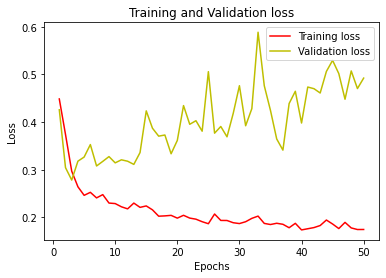

In [32]:
n_epochs = 50
train_nn(model, optimizer, train_loader, val_loader, device, n_epochs)

In [33]:
save_checkpoint(model, n_epochs, optimizer)

# Testing

Try on sample images

In [34]:
# we will watch first epoich to ensure no errrors
# while it is training, lets write code to see the models predictions. lets try again
model.eval()
torch.cuda.empty_cache()

In [35]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [39]:
img, _ = test_dataset[1:5]
img_int = torch.tensor(img*255, dtype=torch.uint8) 

with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


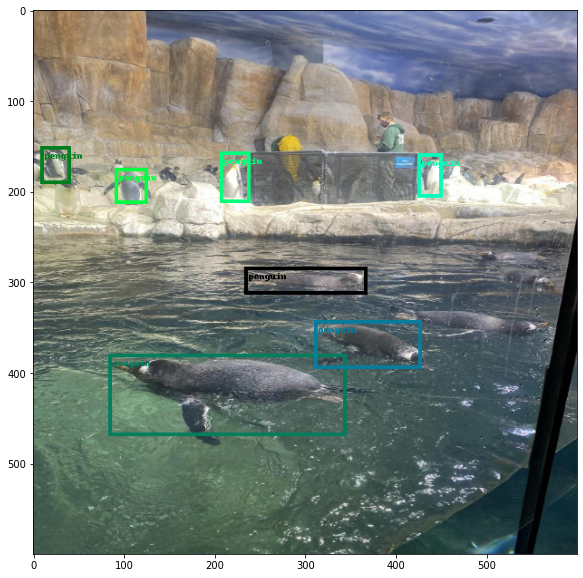

In [40]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))